Now, we'll look at how Snorkel responds to adding new labeling functions. Since the authors claim that the generative model can learn how accurate a labeling function is, we want to test this and see how accurate this claim is.

To test this theory, we'll recreate the original experiment again, except this time we're going to focus on the generative model instead of the discriminative model. We'll explore the results with the original set of labeling functions, as well as seeing how well the generative model responds to adding in a good and a bad labeling function.

Our "good" labeling function is a lookup table that returns the gold label for every item in the development set. If the generative model is as good as the Snorkel authors claim, it should be able to learn something about the accuracy of other labeling functions based on this lookup table, and the overall accuracy should improve.

Our "bad" labeling function will return an essentially random label for every item. It will take the hash of a candidate sentence, and return the last bit of that hash. This labeling function will provide absolutely no new information, which the generative model should be able to learn. If the model learns that this random function is inconsistent and does not align well with the other labeling functions, it should be mostly disregarded.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession

session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()

In [3]:
import bz2
from six.moves.cPickle import load

with bz2.BZ2File('data/ctd.pkl.bz2', 'rb') as ctd_f:
    ctd_unspecified, ctd_therapy, ctd_marker = load(ctd_f)

In [4]:
def cand_in_ctd_unspecified(c):
    return 1 if c.get_cids() in ctd_unspecified else 0

def cand_in_ctd_therapy(c):
    return 1 if c.get_cids() in ctd_therapy else 0

def cand_in_ctd_marker(c):
    return 1 if c.get_cids() in ctd_marker else 0

In [5]:
def LF_in_ctd_unspecified(c):
    return -1 * cand_in_ctd_unspecified(c)

def LF_in_ctd_therapy(c):
    return -1 * cand_in_ctd_therapy(c)

def LF_in_ctd_marker(c):
    return cand_in_ctd_marker(c)

In [6]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

def LF_induce(c):
    return 1 if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else 0

causal_past = ['induced', 'caused', 'due']
def LF_d_induced_by_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + '.{0,9}(by|to).{0,50}', 1)
def LF_d_induced_by_c_tight(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + ' (by|to) ', 1)

def LF_induce_name(c):
    return 1 if 'induc' in c.chemical.get_span().lower() else 0     

causal = ['cause[sd]?', 'induce[sd]?', 'associated with']
def LF_c_cause_d(c):
    return 1 if (
        re.search(r'{{A}}.{0,50} ' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
        and not re.search('{{A}}.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
    ) else 0

treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap']
def LF_d_treat_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_treat_d(c):
    return rule_regex_search_before_B(c, ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d_wide(c):
    return rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', -1)

def LF_c_d(c):
    return 1 if ('{{A}} {{B}}' in get_tagged_text(c)) else 0

def LF_c_induced_d(c):
    return 1 if (
        ('{{A}} {{B}}' in get_tagged_text(c)) and 
        (('-induc' in c[0].get_span().lower()) or ('-assoc' in c[0].get_span().lower()))
        ) else 0

def LF_improve_before_disease(c):
    return rule_regex_search_before_B(c, 'improv.*', -1)

pat_terms = ['in a patient with ', 'in patients with']
def LF_in_patient_with(c):
    return -1 if re.search(ltp(pat_terms) + '{{B}}', get_tagged_text(c), flags=re.I) else 0

uncertain = ['combin', 'possible', 'unlikely']
def LF_uncertain(c):
    return rule_regex_search_before_A(c, ltp(uncertain) + '.*', -1)

def LF_induced_other(c):
    return rule_regex_search_tagged_text(c, '{{A}}.{20,1000}-induced {{B}}', -1)

def LF_far_c_d(c):
    return rule_regex_search_btw_AB(c, '.{100,5000}', -1)

def LF_far_d_c(c):
    return rule_regex_search_btw_BA(c, '.{100,5000}', -1)

def LF_risk_d(c):
    return rule_regex_search_before_B(c, 'risk of ', 1)

def LF_develop_d_following_c(c):
    return 1 if re.search(r'develop.{0,25}{{B}}.{0,25}following.{0,25}{{A}}', get_tagged_text(c), flags=re.I) else 0

procedure, following = ['inject', 'administrat'], ['following']
def LF_d_following_c(c):
    return 1 if re.search('{{B}}.{0,50}' + ltp(following) + '.{0,20}{{A}}.{0,50}' + ltp(procedure), get_tagged_text(c), flags=re.I) else 0

def LF_measure(c):
    return -1 if re.search('measur.{0,75}{{A}}', get_tagged_text(c), flags=re.I) else 0

def LF_level(c):
    return -1 if re.search('{{A}}.{0,25} level', get_tagged_text(c), flags=re.I) else 0

def LF_neg_d(c):
    return -1 if re.search('(none|not|no) .{0,25}{{B}}', get_tagged_text(c), flags=re.I) else 0

WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

def LF_weak_assertions(c):
    return -1 if re.search(WEAK_RGX, get_tagged_text(c), flags=re.I) else 0

In [7]:
def LF_ctd_marker_c_d(c):
    return LF_c_d(c) * cand_in_ctd_marker(c)

def LF_ctd_marker_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_marker(c)

def LF_ctd_therapy_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_therapy(c)

def LF_ctd_unspecified_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_unspecified(c)

def LF_ctd_unspecified_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_unspecified(c)

In [8]:
def LF_closer_chem(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(dis_end, min(len(sent.words), dis_end + dist // 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    for i in range(max(0, dis_start - dist // 2), dis_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    return 0

def LF_closer_dis(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical disease than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist // 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    for i in range(max(0, chem_start - dist // 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    return 0

Here, we'll create some more labeling functions to see how the Snorkel generative model responds to adding in good or bad labeling functions

In [9]:
from difflib import SequenceMatcher

# now that we've recreated the generative model from the tutorial, let's play with it. Here I define two new labeling functions:
def random(c):
    return 1 if hash(get_tagged_text(c))%2==0 else -1

def random_low(c):
    # give random labels for ~20% of the candidates
    if hash(get_tagged_text(c)) % 5 == 0:
        if hash(get_tagged_text(c)) % 10 == 0:
            return 1
        else:
            return -1
    return 0

all_tagged_dev = [get_tagged_text(c) for c in dev_cands]
def lookup(c):
    for i,s in enumerate(all_tagged_dev):
        if s != get_tagged_text(c):
            continue
        t = dev_cands[i]
        if t.chemical.get_word_start() == c.chemical.get_word_start() and t.disease.get_word_start() == c.disease.get_word_start() and t.chemical.get_word_end() == c.chemical.get_word_end() and t.disease.get_word_end() == c.disease.get_word_end():
            return int(L_gold_dev.toarray()[i][0])
    return 0

In [10]:
basic_LFs = [
    LF_c_cause_d,
    LF_c_d,
    LF_c_induced_d,
    LF_c_treat_d,
    LF_c_treat_d_wide,
    LF_closer_chem,
    LF_closer_dis,
    LF_ctd_marker_c_d,
    LF_ctd_marker_induce,
    LF_ctd_therapy_treat,
    LF_ctd_unspecified_treat,
    LF_ctd_unspecified_induce,
    LF_d_following_c,
    LF_d_induced_by_c,
    LF_d_induced_by_c_tight,
    LF_d_treat_c,
    LF_develop_d_following_c,
    LF_far_c_d,
    LF_far_d_c,
    LF_improve_before_disease,
    LF_in_ctd_therapy,
    LF_in_ctd_marker,
    LF_in_patient_with,
    LF_induce,
    LF_induce_name,
    LF_induced_other,
    LF_level,
    LF_measure,
    LF_neg_d,
    LF_risk_d,
    LF_treat_d,
    LF_uncertain,
    LF_weak_assertions,
]

In [11]:
LFs_with_random = basic_LFs.copy()
LFs_with_random.append(random)
LFs_with_random_low = basic_LFs.copy()
LFs_with_random_low.append(random_low)
LFs_with_lookup = basic_LFs.copy()
LFs_with_lookup.append(lookup)

In [12]:
from load_external_annotations import load_external_labels
load_external_labels(session, ChemicalDisease, split=1, annotator='gold')

AnnotatorLabels created: 0


In [13]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold',split=2)
L_gold_test

<4683x1 sparse matrix of type '<class 'numpy.int64'>'
	with 4683 stored elements in Compressed Sparse Row format>

In [14]:
from snorkel.annotations import LabelAnnotator
labeler_orig = LabelAnnotator(lfs=basic_LFs)
labeler_with_random = LabelAnnotator(lfs=LFs_with_random)
labeler_with_random_low = LabelAnnotator(lfs=LFs_with_random_low)
labeler_with_lookup = LabelAnnotator(lfs = LFs_with_lookup)

In [25]:
%time L_train_orig = labeler_orig.apply(split=0)
%time L_train_random = labeler_with_random.apply(split=0)
%time L_train_random_low = labeler_with_random_low.apply(split=0)
%time L_train_lookup = labeler_with_lookup.apply(split=0)

  0%|          | 24/8433 [00:00<00:35, 235.51it/s]

Clearing existing...
Running UDF...


  0%|          | 24/8433 [00:00<00:36, 231.72it/s]

CPU times: user 32.9 s, sys: 641 ms, total: 33.5 s
Wall time: 34 s
Clearing existing...
Running UDF...


  0%|          | 26/8433 [00:00<00:33, 252.73it/s]

CPU times: user 33.5 s, sys: 281 ms, total: 33.8 s
Wall time: 33.8 s
Clearing existing...
Running UDF...


100%|██████████| 8433/8433 [00:32<00:00, 262.02it/s]


CPU times: user 31.9 s, sys: 266 ms, total: 32.2 s
Wall time: 32.3 s
Clearing existing...


  0%|          | 12/8433 [00:00<01:15, 111.35it/s]

Running UDF...


100%|██████████| 8433/8433 [01:18<00:00, 108.11it/s]


CPU times: user 1min 17s, sys: 562 ms, total: 1min 18s
Wall time: 1min 18s


In [27]:
%time L_dev_orig = labeler_orig.apply(split=1)
%time L_dev_random = labeler_with_random.apply(split=1)
%time L_dev_random_low = labeler_with_random_low.apply(split=1)
%time L_dev_lookup = labeler_with_lookup.apply(split=1)

  3%|▎         | 24/920 [00:00<00:03, 234.65it/s]

Clearing existing...
Running UDF...


  3%|▎         | 25/920 [00:00<00:03, 246.51it/s]

CPU times: user 3.67 s, sys: 78.1 ms, total: 3.75 s
Wall time: 3.75 s
Clearing existing...
Running UDF...


  3%|▎         | 26/920 [00:00<00:03, 253.09it/s]

CPU times: user 3.69 s, sys: 15.6 ms, total: 3.7 s
Wall time: 3.75 s
Clearing existing...
Running UDF...


  2%|▏         | 15/920 [00:00<00:06, 149.07it/s]

CPU times: user 3.58 s, sys: 31.2 ms, total: 3.61 s
Wall time: 3.62 s
Clearing existing...
Running UDF...


100%|██████████| 920/920 [00:07<00:00, 117.46it/s]

CPU times: user 7.69 s, sys: 203 ms, total: 7.89 s
Wall time: 7.88 s


In [29]:
# need to extend these to include dev/train in the same thing
# will also be useful to start pickling all these things to save time when re running stuff
from scipy import sparse
import numpy as np
total_orig = sparse.csr_matrix(np.concatenate([L_train_orig.toarray(),L_dev_orig.toarray()]))
total_random = sparse.csr_matrix(np.concatenate([L_train_random.toarray(),L_dev_random.toarray()]))
total_random_low = sparse.csr_matrix(np.concatenate([L_train_random_low.toarray(),L_dev_random_low.toarray()]))
total_lookup = sparse.csr_matrix(np.concatenate([L_train_lookup.toarray(),L_dev_lookup.toarray()]))

In [30]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps_orig = ds.select(total_orig, threshold=0.1)
deps_random = ds.select(total_random, threshold=0.1)
deps_random_low = ds.select(total_random, threshold=0.1)
deps_lookup = ds.select(total_lookup, threshold=0.1)
print(len(deps_orig), len(deps_random), len(deps_random_low), len(deps_lookup))

244 243 243 245


In [32]:
from snorkel.learning import GenerativeModel

gen_model_orig = GenerativeModel(lf_propensity=True)
gen_model_random = GenerativeModel(lf_propensity=True)
gen_model_random_low = GenerativeModel(lf_propensity=True)
gen_model_lookup = GenerativeModel(lf_propensity=True)

gen_model_orig.train(
    total_orig, deps=deps_orig, decay=0.95, step_size=0.1/total_orig.shape[0], reg_param=0.0
)
gen_model_random.train(
    total_random, deps=deps_random, decay=0.95, step_size=0.1/total_random.shape[0], reg_param=0.0
)
gen_model_random_low.train(
    total_random_low, deps=deps_random_low, decay=0.95, step_size=0.1/total_random_low.shape[0], reg_param=0.0
)
gen_model_lookup.train(
    total_lookup, deps=deps_lookup, decay=0.95, step_size=0.1/total_lookup.shape[0], reg_param=0.0
)

Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2


In [33]:
train_marginals_orig = gen_model_orig.marginals(total_orig)
train_marginals_random = gen_model_random.marginals(total_random)
train_marginals_random_low = gen_model_random_low.marginals(total_random_low)
train_marginals_lookjup = gen_model_lookup.marginals(total_lookup)

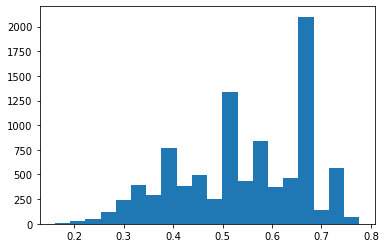

In [34]:
import matplotlib.pyplot as plt
plt.hist(train_marginals_orig, bins=20)
plt.show()

In [35]:
L_train_random_low.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_c_cause_d,0,0.031661,0.028815,0.014348
LF_c_d,1,0.021819,0.019210,0.007589
LF_c_induced_d,2,0.004150,0.004150,0.002134
LF_c_treat_d,3,0.047551,0.047551,0.021819
LF_c_treat_d_wide,4,0.088462,0.088106,0.042215
LF_closer_chem,5,0.188426,0.173129,0.101387
LF_closer_dis,6,0.014704,0.014230,0.009368
LF_ctd_marker_c_d,7,0.017669,0.017669,0.006641
LF_ctd_marker_induce,8,0.020396,0.020396,0.009131
LF_ctd_therapy_treat,9,0.047196,0.047196,0.019566


In [36]:
gen_model_orig.learned_lf_stats()

/home/cperreault/snorkel-extraction/snorkel/learning/gen_learning.py:350: RuntimeWarning: invalid value encountered in double_scalars
  "Precision": tp / (tp + fp),
/home/cperreault/snorkel-extraction/snorkel/learning/gen_learning.py:352: RuntimeWarning: invalid value encountered in double_scalars
  "Accuracy": (tp + tn) / coverage,


,Accuracy,Coverage,Precision,Recall
0,0.551020,0.0049,0.521739,0.002405
1,0.514286,0.0035,0.444444,0.001604
2,0.500000,0.0004,1.000000,0.000401
3,0.642857,0.0028,0.727273,0.001604
4,0.560748,0.0214,0.588235,0.012026
5,0.601314,0.0913,0.582418,0.053117
6,0.333333,0.0003,0.500000,0.000200
7,0.357143,0.0014,0.000000,0.000000
8,0.400000,0.0035,0.368421,0.001403
9,0.590909,0.0132,0.578125,0.007416


In [37]:
gen_model_random.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.394737,0.0038,0.500000,0.001640
1,0.414634,0.0041,0.500000,0.002255
2,0.000000,0.0002,NaN,0.000000
3,0.485714,0.0035,0.450000,0.001845
4,0.536364,0.0220,0.529412,0.012918
5,0.574121,0.0796,0.547500,0.044905
6,0.666667,0.0006,0.000000,0.000000
7,0.600000,0.0020,0.818182,0.001845
8,0.625000,0.0032,0.611111,0.002255
9,0.517483,0.0143,0.500000,0.008407


In [38]:
gen_model_random_low.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.630435,0.0046,0.478261,0.002204
1,0.566667,0.0030,0.500000,0.001403
2,0.000000,0.0001,NaN,0.000000
3,0.500000,0.0026,0.357143,0.001002
4,0.583710,0.0221,0.530000,0.010621
5,0.627828,0.0884,0.643021,0.056313
6,0.166667,0.0006,0.166667,0.000200
7,0.470588,0.0017,0.142857,0.000200
8,0.647059,0.0034,0.857143,0.002405
9,0.591667,0.0120,0.524590,0.006413


In [39]:
gen_model_lookup.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.471910,0.0089,0.400000,0.002744
1,0.430769,0.0065,0.705882,0.002352
2,0.382353,0.0034,1.000000,0.000196
3,0.325000,0.0040,0.500000,0.001372
4,0.474178,0.0213,0.509434,0.010584
5,0.593312,0.0927,0.602620,0.054096
6,0.350000,0.0040,0.166667,0.000196
7,0.387755,0.0049,0.538462,0.001372
8,0.456140,0.0057,0.529412,0.001764
9,0.487395,0.0119,0.591837,0.005684


In [40]:
_ = gen_model_lookup.error_analysis(session, L_dev_lookup, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.984
Neg. class accuracy: 0.811
Precision            0.722
Recall               0.984
F1                   0.833
----------------------------------------
TP: 301 | FP: 116 | TN: 498 | FN: 5



In [41]:
_ = gen_model_lookup.error_analysis(session, L_dev_orig, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.892
Neg. class accuracy: 0.621
Precision            0.54
Recall               0.892
F1                   0.672
----------------------------------------
TP: 273 | FP: 233 | TN: 381 | FN: 33



In [42]:
_ = gen_model_lookup.error_analysis(session, L_dev_random, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.824
Neg. class accuracy: 0.497
Precision            0.449
Recall               0.824
F1                   0.581
----------------------------------------
TP: 252 | FP: 309 | TN: 305 | FN: 54



In [45]:
_ = gen_model_lookup.error_analysis(session, L_dev_random_low, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.899
Neg. class accuracy: 0.607
Precision            0.533
Recall               0.899
F1                   0.669
----------------------------------------
TP: 275 | FP: 241 | TN: 373 | FN: 31



In [ ]:
L_dev_lookup.lf_stats(session, L_gold_dev, gen_model_lookup.learned_lf_stats()['Accuracy'])

In [ ]:
# stats to check: learned accuracy vs empirical accuracy of the new labeling function, 
# comparison of weighted averages of error in other learned accuracies.

In [346]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session,annotator_name='gold',split=2)

In [23]:
%time L_test_orig = labeler_orig.apply(split=2)
# %time L_test_random = labeler_with_random.apply(split=2)
# %time L_test_random_low = labeler_with_random_low.apply(split=2)
# %time L_test_lookup = labeler_with_lookup.apply(split=2)

  1%|          | 26/4683 [00:00<00:18, 257.01it/s]

Clearing existing...
Running UDF...


100%|██████████| 4683/4683 [00:17<00:00, 263.06it/s]

CPU times: user 17.9 s, sys: 250 ms, total: 18.2 s
Wall time: 18 s


In [24]:
_ = gen_model_orig.error_analysis(session, L_test_orig, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.95
Neg. class accuracy: 0.636
Precision            0.555
Recall               0.95
F1                   0.701
----------------------------------------
TP: 1439 | FP: 1152 | TN: 2017 | FN: 75



In [48]:
_ = gen_model_random.error_analysis(session, L_test_random, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.503
Neg. class accuracy: 0.491
Precision            0.321
Recall               0.503
F1                   0.392
----------------------------------------
TP: 762 | FP: 1614 | TN: 1555 | FN: 752



In [49]:
_ = gen_model_random_low.error_analysis(session, L_test_random_low, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.921
Neg. class accuracy: 0.613
Precision            0.532
Recall               0.921
F1                   0.674
----------------------------------------
TP: 1394 | FP: 1227 | TN: 1942 | FN: 120



In [50]:
_ = gen_model_lookup.error_analysis(session, L_test_lookup, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.941
Neg. class accuracy: 0.642
Precision            0.557
Recall               0.941
F1                   0.7
----------------------------------------
TP: 1425 | FP: 1134 | TN: 2035 | FN: 89



In [53]:
train_marginals_orig# = gen_model_orig.marginals(total_orig)
# train_marginals_random = gen_model_random.marginals(total_random)
# train_marginals_random_low = gen_model_random_low.marginals(total_random_low)
# train_marginals_lookjup = gen_model_lookup.marginals(total_lookup)
train_marginals_orig.tofile("train_marginals_orig.txt")
train_marginals_random.tofile("train_marginals_random.txt")
train_marginals_random_low.tofile("train_marginals_random_low.txt")
train_marginals_lookjup.tofile("train_marginals_lookup.txt")